Group 7 Opti project:  

> The scenario of our project is that we want to start a small food delivery business within SUTD, with our 4 members as the riders  
- The goal of the project is to minimize the number of drivers we employ while fulfilling all the demand each hour   
- The demand data is obtained through a survey done by the SUTD population  
- We employ drivers by the hour



> Some possible ideas for improving the model:  
- Adding a indicator variable to model a possible condition (e.g. We have a friend who only wants to work when demand exceeds a certain level, so a fifth driver (x5) would only be available if d exceeds a certain amount)
- Adding additional constraints to model: Driver 1 & 4 don't like working with each other, so if x1 is 1, x4 cannot be 1 & vice versa


In [ ]:
# Import
import matplotlib.pyplot as plt
import pandas as pd

# Read the data from an Excel file
df = pd.read_excel('demand_counts.xlsx') 

# Extract the hour from the Time Slot column
df['Hour'] = df['Time Slot'].str.split('-').str[0].str.strip()

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(df['Hour'], df['Count'])

# Set the title and labels
plt.title('Count by Time Slot (Start)')
plt.xlabel('Time Slot (Start)')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
using MosekTools, JuMP

------START OF MODEL------   
Objective function:

In [ ]:
#Start the model
m = Model(Mosek.Optimizer)
n = 4 #Number of drivers
k = 24 #Number of hours in the day
d = [11 10 13 2 0 0 5 9 12 16 17 4 25 28 8 2 1 4 20 23 14 5 2 2] # Demand in each hour

p = [3 4 2 1] # Productivity of each driver      # idea is to randomize this as an input for the driver's productivity

#Start variables
@variable(m, x[1:n,1:k], Bin) # Whether I employ driver i in hour j

#Start constraints and objective
@constraint(m, [j=1:k], sum(p[i] * x[i, j] for i in 1:n) >= d[j]) # the sum of (productivity of driver i * whether or not that driver is 
                                                                  # employed in hour i)
                                                                  # across all drivers must be more than or equals to the demand for that hour i

@objective(m, Min, sum(x[i, j] for i in 1:n, j in 1:k))
print(m)






In [ ]:
optimize!(m)

In [ ]:
value.(x)

In [ ]:
objective_value(m)

> We got bought over by a STEP student & get paid now. This scenario is now from the perspective of the owner
- The goal is to minimize total cost (Fixed & variable cost) while meeting the demand in every hour in every hotspot
- Variable cost is straight line distance, fixed cost is salary
- Every hour's total demand is split randomly into k "hotspots"
- The driver's and demand hotspot locations are fixed (HQ hotspots)

> Problems of model
- Problem feasibility still limited by the p vector 
- Only variable cost stops most productive driver from doing everything

In [1]:
using JuMP, MosekTools, LinearAlgebra, Random, Plots
import LinearAlgebra
import Plots
import Random

In [43]:
# Helper function to randomly split an integer into n positive integers
function random_split(total::Int, n::Int)
    cuts = sort(rand(1:total-1, n-1))
    return diff([0; cuts; total])
end

random_split (generic function with 1 method)

In [44]:
n=10
k=24
d = [22 20 26 4 0 0 10 19 24 32 34 4 25 50 8 2 1 4 20 23 14 5 2 2]

d_short = filter(x -> x in partialsort(vec(d), 1:3; rev=true), vec(d))[1:3] # Automatically extract top 3 values

# Create 15 sets of x and y coordinates, to be used in my (x_c,y_c, demand) tuple
x_c = rand(15) # 15 is arbitrary to simplify the number of deliver-to locations/hotspots
y_c = rand(15)

# Random start locations for each driver
x_f = rand(n)
y_f = rand(n)

# Split demand into 15 elements, 5 x length of d_short
tuples = []
for i in 1:length(d_short)
    total_demand = d_short[i]
    demand_split = random_split(total_demand, 15)  # 15 splits for each element of d_short

    # Create 15 tuples for the current d_short value
    for j in 1:15
        push!(tuples, (x_c[j], y_c[j], demand_split[j]))
    end
end

In [47]:
c = zeros(15, n) # I'm creating a 15xn matrix. Each matrix is fixed for that hour,
                # and the rows are the order hotspots while the columns are the drivers.                  
                # Each cell is the variable cost incurred for assigning driver i to order demand hotspot j
for i in 1:15
    for j in 1:n
        c[i, j] = norm([x_c[i] - x_f[j], y_c[i] - y_f[j]])
    end
end

Any[(0.6112865052683841, 0.13622310606583188, 2), (0.6903387978081017, 0.0736871437668084, 1), (0.8283326327145029, 0.22273211192766973, 2), (0.053854671688094546, 0.44575563670816654, 1), (0.8780866872111001, 0.2982969974081352, 0), (0.77121538188585, 0.5093863914696515, 0), (0.26958024621621135, 0.6026017440402046, 2), (0.3168193124586214, 0.756831432595035, 9), (0.23828508058007503, 0.9611568203180111, 1), (0.9799324965895889, 0.48365096595725576, 0), (0.9244416163852744, 0.39011462574382305, 1), (0.06724709672641094, 0.8409562122525289, 3), (0.04994191319886976, 0.3794890246287863, 0), (0.4230122913356149, 0.9019587444183562, 7), (0.21801687889279142, 0.11724971342878443, 3)]

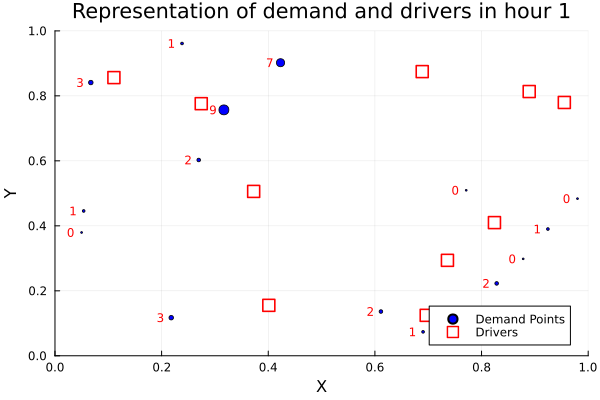

Any[(0.6112865052683841, 0.13622310606583188, 4), (0.6903387978081017, 0.0736871437668084, 6), (0.8283326327145029, 0.22273211192766973, 1), (0.053854671688094546, 0.44575563670816654, 0), (0.8780866872111001, 0.2982969974081352, 5), (0.77121538188585, 0.5093863914696515, 0), (0.26958024621621135, 0.6026017440402046, 2), (0.3168193124586214, 0.756831432595035, 3), (0.23828508058007503, 0.9611568203180111, 1), (0.9799324965895889, 0.48365096595725576, 0), (0.9244416163852744, 0.39011462574382305, 2), (0.06724709672641094, 0.8409562122525289, 1), (0.04994191319886976, 0.3794890246287863, 0), (0.4230122913356149, 0.9019587444183562, 7), (0.21801687889279142, 0.11724971342878443, 2)]

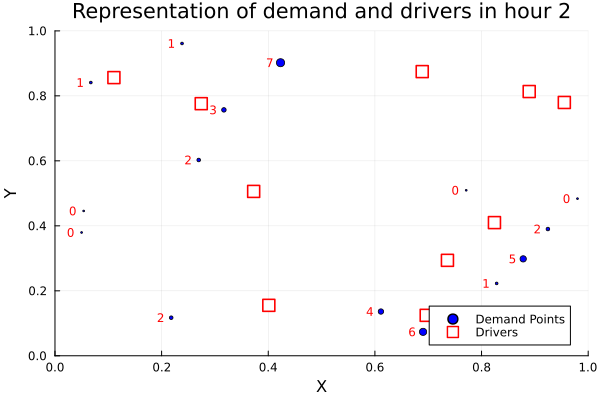

Any[(0.6112865052683841, 0.13622310606583188, 2), (0.6903387978081017, 0.0736871437668084, 2), (0.8283326327145029, 0.22273211192766973, 2), (0.053854671688094546, 0.44575563670816654, 1), (0.8780866872111001, 0.2982969974081352, 3), (0.77121538188585, 0.5093863914696515, 1), (0.26958024621621135, 0.6026017440402046, 2), (0.3168193124586214, 0.756831432595035, 1), (0.23828508058007503, 0.9611568203180111, 10), (0.9799324965895889, 0.48365096595725576, 2), (0.9244416163852744, 0.39011462574382305, 8), (0.06724709672641094, 0.8409562122525289, 7), (0.04994191319886976, 0.3794890246287863, 4), (0.4230122913356149, 0.9019587444183562, 3), (0.21801687889279142, 0.11724971342878443, 2)]

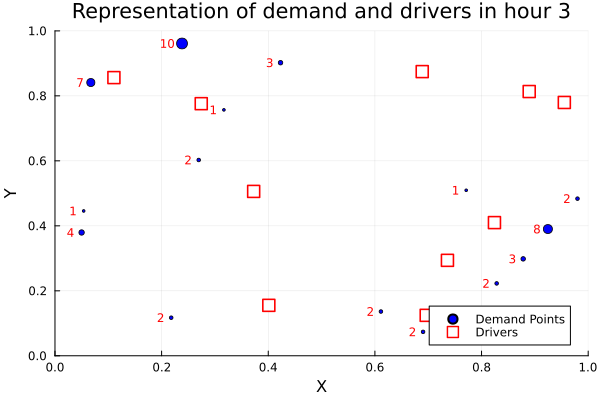

In [49]:
using Plots

# Number of plots (3 different sets of demand locations)
n_plots = 3

# Plotting the 3 graphs
for i in 1:n_plots
    # Select the corresponding 15 tuples for the current plot
    current_tuples = tuples[(i-1)*15 + 1:i*15]
    print(current_tuples)

    # Extract the x_c, y_c values (demand locations)
    x_c = [t[1] for t in current_tuples]
    y_c = [t[2] for t in current_tuples]
    d = [t[3] for t in current_tuples]  # demand values
    
    # Create the scatter plot for demand points
    p = scatter(
        x_c, y_c;
        label = "Demand Points",
        markershape = :circle,
        markercolor = :blue,
        markersize = 0.5 .* (2 .+ d),
        title = "Representation of demand and drivers in hour $(i)",
        xlabel = "X",
        ylabel = "Y",
        xlims = (0, 1),
        ylims = (0, 1)
    )
    
    # Annotate each demand point slightly to the left with red text
    for (xi, yi, di) in zip(x_c, y_c, d)
        annotate!(p, xi - 0.015, yi, text(string(di), 8, :red, :right))
    end
    
    # Add the driver points (constant across plots)
    scatter!(p,
        x_f, y_f;
        label = "Drivers",
        markershape = :rect,
        markercolor = :white,
        markersize = 6,
        markerstrokecolor = :red,
        markerstrokewidth = 2
    )

    # Display the plot
    display(p)
end


> Hour 1's model!

In [56]:
# Start the model
model = Model(Mosek.Optimizer)
n = 10 # Number of drivers
k = 24 # Number of hours in the day
l = 15 #number of hotspots


# Productivity & energy of drivers
pr = [3 4 2 1 1 2 3 4 3 2]                         # Still can randomize this OR draw from normal dist
fixed_c = [2]

# Variables
@variable(model, y[1:n, 1:l], Bin)

# Constraints
for j in 1:l # For every hotspot, sum of all driver's productivity must meet or exceed demand
    @constraint(model, sum(y[i,j]*pr[i] for i in 1:n) >= tuples[j][3]) # Tuples is a vector that has  tuples that contains the x_coord,
                                                                       # y_coord and the demand
end

for j in 1:l # For every hotspot, at least one driver must be assigned, to prevent driver-less hotspots
    @constraint(model, sum(y[i,j] for i in 1:n) >= 1)
end

# Objective
@objective(model, Min,                             
    sum(y[i,j]*fixed_c[1] for i in 1:n, j in 1:l) + # Fixed component
    sum(y[i,j] * c[j,i] for i in 1:n, j in 1:l)     # Variable component based on distance
    )

print(model)

In [57]:
optimize!(model)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : LO (linear optimization problem)
  Constraints            : 180             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 150             
  Matrix variables       : 0               
  Integer variables      : 150             

Optimizer started.
Mixed integer optimizer started.
Threads used: 12
Presolve started.
Presolve terminated. Time = 0.00, probing time =  0.00
Presolved problem: 150 variables, 22 constraints, 220 non-zeros
Presolved problem: 0 general integer, 150 binary, 0 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        0        1        0        4.1484766269e+01     NA                   NA          0.0   
0        1        1        0        3.9969890235e+0

In [58]:
value.(y)

10×15 Matrix{Float64}:
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0   0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0   0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0   1.0   1.0  …   1.0   1.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0   1.0  -0.0   1.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0   1.0  -0.0
  1.0   1.0   1.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0   1.0
 -0.0  -0.0  -0.0   1.0  -0.0  -0.0     -0.0  -0.0  -0.0   1.0  -0.0  -0.0

In [59]:
objective_value(model)

39.35780899887511

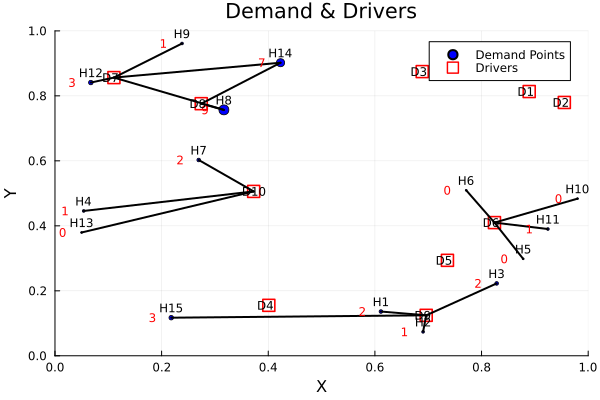

In [60]:
using Plots

# (Assume you’ve already done optimize!(model) and have y_val, x_f, y_f, tuples, etc.)

y_val = value.(y) # optimized assignments

# Extract data for plotting
current_tuples = tuples[1:15]
x_c = [t[1] for t in current_tuples]
y_c = [t[2] for t in current_tuples]
d   = [t[3] for t in current_tuples]

# Define common plot attributes for demand points
demand_point_attrs = (
    label       = "Demand Points",
    markershape = :circle,
    markercolor = :blue,
    markersize  = 0.5 .* (2 .+ d),
    legend      = :topright,
    legendfontsize = 8
)

# Define common plot attributes for drivers
driver_attrs = (
    label           = "Drivers",
    markershape     = :rect,
    markercolor     = :white,
    markersize      = 6,
    markerstrokecolor = :red,
    markerstrokewidth = 2
)

# Initialize the plot with Demand Points
p = scatter(
    x_c, y_c;
    demand_point_attrs..., 
    title           = "Demand & Drivers",
    xlabel          = "X",
    ylabel          = "Y",
    xlims           = (0,1),
    ylims           = (0,1)
)

# Label hotspots and numeric demand for demand points
for (idx, xi, yi, di) in zip(1:length(x_c), x_c, y_c, d)
    # Hotspot label (e.g., H1)
    annotate!(p, xi, yi + 0.03, text("H$(idx)", 8, :black, :center))
    # Numeric demand (e.g., 50)
    annotate!(p, xi - 0.03, yi, text(string(di), 8, :red, :right))
end

# Add Drivers to the plot
scatter!(p, x_f, y_f; driver_attrs...)

# Label each driver
for (idx, xi, yi) in zip(1:n_drivers, x_f, y_f)
    annotate!(p, xi - 0.02, yi, text("D$(idx)", 8, :black, :left))
end

# Draw assignment lines
for j in 1:n_demand, i in 1:n_drivers
    if y_val[i,j] == 1
        plot!(p, [x_c[j], x_f[i]], [y_c[j], y_f[i]];
              color = :black, label = "", linewidth = 2)
    end
end

display(p)

> Hour 2!

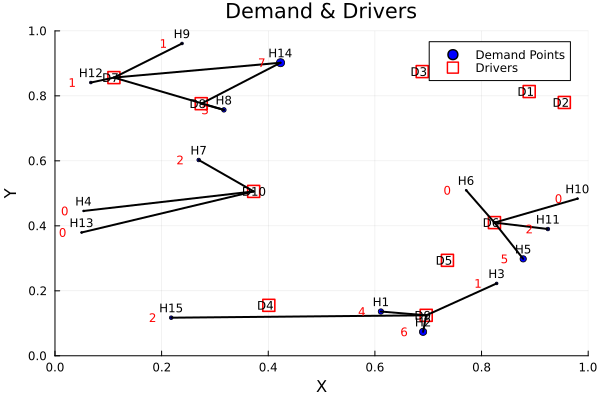

In [61]:
using Plots

# (Assume you’ve already done optimize!(model) and have y_val, x_f, y_f, tuples, etc.)

y_val = value.(y) # optimized assignments

# Extract data for plotting
current_tuples = tuples[16:30]
x_c = [t[1] for t in current_tuples]
y_c = [t[2] for t in current_tuples]
d   = [t[3] for t in current_tuples]

# Define common plot attributes for demand points
demand_point_attrs = (
    label       = "Demand Points",
    markershape = :circle,
    markercolor = :blue,
    markersize  = 0.5 .* (2 .+ d),
    legend      = :topright,
    legendfontsize = 8
)

# Define common plot attributes for drivers
driver_attrs = (
    label           = "Drivers",
    markershape     = :rect,
    markercolor     = :white,
    markersize      = 6,
    markerstrokecolor = :red,
    markerstrokewidth = 2
)

# Initialize the plot with Demand Points
p = scatter(
    x_c, y_c;
    demand_point_attrs..., 
    title           = "Demand & Drivers",
    xlabel          = "X",
    ylabel          = "Y",
    xlims           = (0,1),
    ylims           = (0,1)
)

# Label hotspots and numeric demand for demand points
for (idx, xi, yi, di) in zip(1:length(x_c), x_c, y_c, d)
    # Hotspot label (e.g., H1)
    annotate!(p, xi, yi + 0.03, text("H$(idx)", 8, :black, :center))
    # Numeric demand (e.g., 50)
    annotate!(p, xi - 0.03, yi, text(string(di), 8, :red, :right))
end

# Add Drivers to the plot
scatter!(p, x_f, y_f; driver_attrs...)

# Label each driver
for (idx, xi, yi) in zip(1:n_drivers, x_f, y_f)
    annotate!(p, xi - 0.02, yi, text("D$(idx)", 8, :black, :left))
end

# Draw assignment lines
for j in 1:n_demand, i in 1:n_drivers
    if y_val[i,j] == 1
        plot!(p, [x_c[j], x_f[i]], [y_c[j], y_f[i]];
              color = :black, label = "", linewidth = 2)
    end
end

display(p)

> Hour 3!

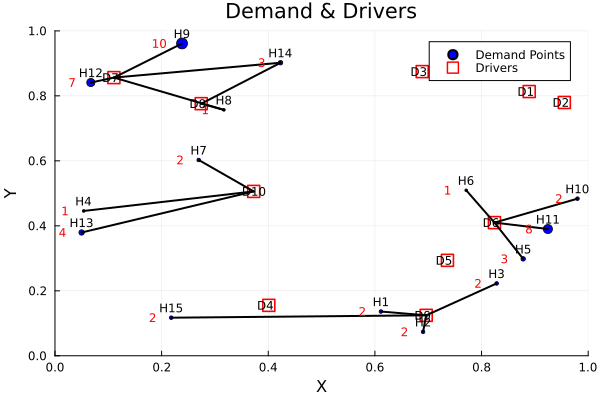

In [62]:
using Plots

# (Assume you’ve already done optimize!(model) and have y_val, x_f, y_f, tuples, etc.)

y_val = value.(y) # optimized assignments

# Extract data for plotting
current_tuples = tuples[31:45]
x_c = [t[1] for t in current_tuples]
y_c = [t[2] for t in current_tuples]
d   = [t[3] for t in current_tuples]

# Define common plot attributes for demand points
demand_point_attrs = (
    label       = "Demand Points",
    markershape = :circle,
    markercolor = :blue,
    markersize  = 0.5 .* (2 .+ d),
    legend      = :topright,
    legendfontsize = 8
)

# Define common plot attributes for drivers
driver_attrs = (
    label           = "Drivers",
    markershape     = :rect,
    markercolor     = :white,
    markersize      = 6,
    markerstrokecolor = :red,
    markerstrokewidth = 2
)

# Initialize the plot with Demand Points
p = scatter(
    x_c, y_c;
    demand_point_attrs..., 
    title           = "Demand & Drivers",
    xlabel          = "X",
    ylabel          = "Y",
    xlims           = (0,1),
    ylims           = (0,1)
)

# Label hotspots and numeric demand for demand points
for (idx, xi, yi, di) in zip(1:length(x_c), x_c, y_c, d)
    # Hotspot label (e.g., H1)
    annotate!(p, xi, yi + 0.03, text("H$(idx)", 8, :black, :center))
    # Numeric demand (e.g., 50)
    annotate!(p, xi - 0.03, yi, text(string(di), 8, :red, :right))
end

# Add Drivers to the plot
scatter!(p, x_f, y_f; driver_attrs...)

# Label each driver
for (idx, xi, yi) in zip(1:n_drivers, x_f, y_f)
    annotate!(p, xi - 0.02, yi, text("D$(idx)", 8, :black, :left))
end

# Draw assignment lines
for j in 1:n_demand, i in 1:n_drivers
    if y_val[i,j] == 1
        plot!(p, [x_c[j], x_f[i]], [y_c[j], y_f[i]];
              color = :black, label = "", linewidth = 2)
    end
end

display(p)